In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.preprocessing import StandardScaler,PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.metrics import confusion_matrix, recall_score, precision_score, plot_confusion_matrix

In [3]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from collections import Counter

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgbClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [5]:
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [6]:
import scikitplot as skplt

In [7]:
%%time
df18=pd.read_excel("Transaction Data.xlsx",sheet_name='Transactions18')
df19=pd.read_excel("Transaction Data.xlsx",sheet_name='Transactions19')
fi=pd.read_excel("Firm Information.xlsx", sheet_name='Rep summary')

Wall time: 18.5 s


In [8]:
def fillna_values(df):    
    '''fill nan values with zero'''     
    if isinstance(df, type(pd.Series(dtype='float64'))):       
        return df.fillna(0)    
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)

Encoding

In [9]:
fi['Channel'].value_counts()

Independent Dealer        6942
National Broker-Dealer    2031
Dual                       476
Fee-Based Adviser          240
Bank/Trust                 181
Private Client Group        49
Asset Manager               48
Discount                    19
Networker                   11
International Outlet         7
Low/Non Producer             1
Name: Channel, dtype: int64

In [10]:
#selecting the n largest firm IDs for encoding, for full_df
firmid=fi['Firm ID'].value_counts().nlargest(5).index.tolist()
fiid=fi.loc[:,'Firm ID'].copy()
for idf,fid in enumerate(fiid):
    if fid not in firmid:
        fiid[idf]='otherid'
fidc=fiid.copy()
fidc=fidc.to_numpy().reshape(-1,1)

In [11]:
markch=['Bank/Trust','Private Client Group','Asset Manager' ,
        'Discount','Networker','International Outlet','Low/Non Producer']

In [12]:
for ma in markch:
    fi['Channel'] = np.where((fi['Channel'] == ma),'other ch' , fi['Channel'])
fi_mc=fi['Channel']
fi_mc=fi_mc.to_numpy().reshape(-1,1)

In [13]:
fi['Channel'].value_counts()

Independent Dealer        6942
National Broker-Dealer    2031
Dual                       476
other ch                   316
Fee-Based Adviser          240
Name: Channel, dtype: int64

In [14]:
#For merging of data dictionary fullff and fullfy
firmid=fi['Firm ID'].value_counts().nlargest(5).index.tolist()
for idf,fid in fi.iterrows():
    if fid['Firm ID'] not in firmid:
        fi.loc[idf,'Firm ID']='otherid' 
#        print('yes',count)
#         count=count+1       

In [15]:
#selecting the marketing sub-channel for encoding 
channels=['Global', 'DCIO', 'Other',
       'Affiliated']
for ch in channels:
    fi['Sub channel'] = np.where((fi['Sub channel'] == ch),'other sub' , fi['Sub channel'])
fi_o=fi['Sub channel']
fi_o=fi_o.to_numpy().reshape(-1,1)

In [16]:
ohe = OneHotEncoder(sparse=False)

In [17]:
#one-hot encoding of marketing sub-channel and largest Firm ids
fi_sub=ohe.fit_transform(fi_o)
fi_ch=pd.DataFrame(fi_sub,columns=['ch1','ch2','ch3','ch4','ch5'])
fi_firm=ohe.fit_transform(fidc)
fi_id=pd.DataFrame(fi_firm,columns=['fid1','fid2','fid3','fid4','fid5','fid6'])
fi_mch=ohe.fit_transform(fi_mc)
fi_mch=pd.DataFrame(fi_mch,columns=['ma1','ma2','ma3','ma4','ma5'])
#concatenation of encoded marketing sub-channel and largest Firm ids
enc=pd.concat((fi.loc[:,'Contact ID'],fi_mch,fi_ch,fi_id),axis=1)

Merging

In [18]:
df18.rename({'CONTACT_ID':'Contact ID'},axis=1,inplace=True)
df19.rename({'CONTACT_ID':'Contact ID'},axis=1,inplace=True)

In [19]:
df18=fillna_values(df18)
df19=fillna_values(df19)

In [20]:
fullfeat=pd.merge(df18, enc, on = 'Contact ID')

In [21]:
fullff=pd.merge(df18, fi, on = 'Contact ID')

In [22]:
fullfy=pd.merge(fullff, df19, on = 'Contact ID',suffixes=['_2018', '_2019'])

In [23]:
full_df=pd.merge(fullfeat, df19, on = 'Contact ID',suffixes=['_2018', '_2019'])

In [24]:
full_df.head()

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,...,ch5,fid1,fid2,fid3,fid4,fid5,fid6,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019
0,21.0,38.0,0.0,1.0,5.0,5.0,0.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18633.105,0.0,2019-12-31
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,2019-12-31
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,2019-12-31
3,20.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,93212.000,1.0,2019-12-31
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,2019-12-31


In [277]:
fullfy.loc[fullfy['Sub channel'] == 'USBT']

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,...,refresh_date_2018,CustomerID,Firm ID,Office ID,Channel,Sub channel,Firm name,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019
315,340.0,227.0,123.0,110.0,7.0,15.0,7.0,12.0,3.0,3.0,...,2018-12-31,8437,otherid,85201103614746836996,other ch,USBT,U.S. Bank Private Wealth Management,7053653.70,1.0,2019-12-31
1433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2018-12-31,4295,otherid,10761193464016414923,Independent Dealer,USBT,TIAA Affiliated,0.00,0.0,2019-12-31
1695,26.0,176.0,10.0,94.0,7.0,21.0,6.0,20.0,3.0,3.0,...,2018-12-31,8951,otherid,85102103784899940124,other ch,USBT,U.S. Bank Private Wealth Management,149032.30,0.0,2019-12-31
1783,391.0,515.0,146.0,153.0,13.0,17.0,11.0,15.0,3.0,4.0,...,2018-12-31,7013,otherid,85201103614683929613,other ch,USBT,U.S. Bank Private Wealth Management,16210684.62,2.0,2019-12-31
2127,11.0,47.0,8.0,32.0,8.0,14.0,7.0,14.0,2.0,3.0,...,2018-12-31,8935,otherid,85201103614780941818,other ch,USBT,U.S. Bank Private Wealth Management,1698750.00,3.0,2019-12-31
2142,90.0,292.0,56.0,116.0,10.0,25.0,9.0,21.0,3.0,4.0,...,2018-12-31,4225,otherid,85201103614692730430,other ch,USBT,U.S. Bank Private Wealth Management,969900.51,1.0,2019-12-31
3022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2018-12-31,5962,otherid,10751193454648672208,Independent Dealer,USBT,TIAA Affiliated,0.00,0.0,2019-12-31
4341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2018-12-31,5966,otherid,10761193464161833474,Independent Dealer,USBT,TIAA Affiliated,0.00,0.0,2019-12-31
5222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2018-12-31,8478,otherid,85102110025403867532,other ch,USBT,U.S. Bank Private Wealth Management,0.00,0.0,2019-12-31
5600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2018-12-31,9431,otherid,85201103614799144268,other ch,USBT,U.S. Bank Private Wealth Management,0.00,0.0,2019-12-31


In [25]:
full_dec=full_df.copy()

Dictionaries

In [26]:
chdec={}
chis=['ch1', 'ch2', 'ch3', 'ch4','ch5']
for cs in chis:
    for idc,rc in full_dec.iterrows():
        if rc[cs]==1.0:
            substr=fullfy.at[idc,'Sub channel']
            chdec[cs]=substr
chdec

{'ch1': 'IBD', 'ch2': 'NACS', 'ch3': 'RIA', 'ch4': 'USBT', 'ch5': 'other sub'}

In [27]:
fdec={}
fis=['fid1', 'fid2', 'fid3', 'fid4', 'fid5', 'fid6']#, 'fid7', 'fid8',
#        'fid9', 'fid10', 'fid11']
for fs in fis:
    for idf,rf in full_dec.iterrows():
        if rf[fs]==1.0:
            fistr=fullfy.at[idf,'Firm ID']
            fdec[fs]=fistr
fdec

{'fid1': '0001194',
 'fid2': '0022885',
 'fid3': '1471422',
 'fid4': '1567450',
 'fid5': '1948520',
 'fid6': 'otherid'}

Data Wrangling continued

In [28]:
full_df['redemption_curr']=full_df['redemption_curr'].abs()
full_df['redemption_12M']=full_df['redemption_12M'].abs()

In [29]:
full_df.drop(['Contact ID', 'refresh_date_2019','refresh_date_2018','sales_12M_2019'], axis=1, inplace=True)

In [30]:
full_df[full_df<0]=0

In [31]:
y=full_df['new_Fund_added_12M_2019']

In [32]:
full_df.drop(['new_Fund_added_12M_2019'], axis=1, inplace=True)

In [33]:
features=full_df.copy()

(array([9.171e+03, 6.450e+02, 1.070e+02, 2.900e+01, 2.000e+01, 2.300e+01,
        7.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

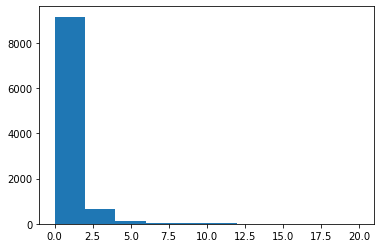

In [34]:
plt.hist(y)

# Feature Selection

In [35]:
# mask = np.triu(np.ones_like(features.corr(), dtype=bool))
# tri_df = features.corr().mask(mask)
# to_drop_high=[c for c in tri_df.columns if any(tri_df[c] > abs(0.59))]
# to_drop_high

In [36]:
# recl=RFE(RandomForestClassifier(n_estimators=100, max_depth=9))

In [37]:
# %%time
# recl.fit(features, y)

In [38]:
# sel_rfe=features.columns[recl.support_] 
# nosel_rfe = [col for col in features.columns if col not in sel_rfe]
# nosel_rfe

In [39]:
# rf=RandomForestClassifier(n_estimators=100, max_depth=9)

In [40]:
# rf.fit(features, y)

In [41]:
# rf_imp=rf.feature_importances_
# rf_imp

In [42]:
# rfim=[]
# for rfi, cl in zip(rf_imp, features.columns):
#     rfim.append((cl,rfi))
# rfim=pd.DataFrame(rfim)
# rfim.sort_values(by=[1], inplace=True, ascending=False)
# rfim.reset_index(drop=True, inplace=True)
# rfim.index += 1 
# rfim.rename({0:'Feature', 1:'Importance'},axis=1,inplace=True)

In [43]:
# rfim

In [44]:
# rf_sel=[]
# for idx,val in enumerate(rf_imp):
#     if val>0.04:
#         rf_sel.append(features.columns[idx])
# rf_sel

In [45]:
# rf_imp=rf.feature_importances_
# # rfr_df=pd.DataFrame(rfr_imp.reshape(1,35),columns=df18col)
# rf_nosel=[]
# for idx,val in enumerate(rf_imp):
#     if val<0.01:
#         rf_nosel.append(features.columns[idx])
# rf_nosel

In [46]:
# bad_cand=rf_nosel+nosel_rfe+to_drop_high
# bad_dict=Counter(bad_cand)
# bad_dict    

In [47]:
# bad_feat=[]
# for ele in bad_dict:
#     if bad_dict[ele]>1:
#         bad_feat.append(ele)
# bad_feat

In [48]:
X=features.copy()
X.drop(['aum_AC_MONEY',
 'aum_AC_REAL_ESTATE',
 'no_of_sales_12M_10K',
 'no_of_Redemption_12M_10K',
 'no_of_funds_redeemed_12M_1',
  'aum_P_ALT','aum_P_UCITS',
        'aum_P_ETF',        
 'no_of_fund_sales_12M_10K',
 'no_of_funds_Redemption_12M_10K',
 'aum_AC_FIXED_INCOME_MUNI'], axis=1, inplace=True)

In [49]:
# Xalt=features[['no_of_sales_12M_1',
#  'no_of_Redemption_12M_1',
#  'no_of_funds_sold_12M_1',
#  'no_of_funds_redeemed_12M_1',
#  'no_of_assetclass_sold_12M_1',
#  'No_of_fund_curr',
#  'AUM',
#  'sales_12M_2018',
#  'redemption_curr',
#  'redemption_12M']]

In [50]:
X

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_funds_sold_12M_1,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,...,ch2,ch3,ch4,ch5,fid1,fid2,fid3,fid4,fid5,fid6
0,21.0,38.0,5.0,2.0,2.0,0.0,1.0,8.0,1.0,237480.110,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19629.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.700,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,20.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,57943.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,12.0,35.0,3.0,2.0,3.0,2.0,3.0,8.0,3.0,430089.060,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10001,85.0,64.0,7.0,3.0,3.0,1.0,0.0,4.0,3.0,170204.585,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10002,18.0,39.0,4.0,2.0,2.0,1.0,1.0,3.0,1.0,0.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10003,34.0,51.0,16.0,5.0,5.0,3.0,3.0,8.0,1.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Applying ML Models

In [51]:
# X_nn=X.copy()
y_nn=y.copy()
y_nn=y_nn.to_numpy().reshape(-1,1)
y_nn=np.where(y_nn!=0,1,0)
pd.DataFrame(y_nn,index=X.index).iloc[:,0].value_counts()

0    7484
1    2521
Name: 0, dtype: int64

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X,y_nn,random_state=30)

In [316]:
pd.DataFrame(y_train,index=X_train.index).iloc[:,0].value_counts()

0    5627
1    1876
Name: 0, dtype: int64

In [317]:
sm = SMOTE(sampling_strategy=0.35)

In [318]:
Xtr_s, ytr_s = sm.fit_resample(X_train,y_train)

In [319]:
pd.DataFrame(ytr_s,index=Xtr_s.index).iloc[:,0].value_counts()

0    5627
1    1969
Name: 0, dtype: int64

In [320]:
pt=PowerTransformer()


In [321]:
Xtr_sp=pt.fit_transform(Xtr_s)
Xts_p=pt.transform(X_test)

In [322]:
pd.DataFrame(y_test,index=X_test.index).iloc[:,0].value_counts()

0    1857
1     645
Name: 0, dtype: int64

In [323]:
1-628/1874

0.6648879402347918

In [324]:
rfc=RandomForestClassifier(n_estimators=100,max_depth=13,class_weight={1: 0.7837,0: 0.2163})

In [325]:
rfc.fit(Xtr_sp,ytr_s)
print("Random Forest Classififer: \n", classification_report(y_test, rfc.predict(Xts_p)), "\n")
print("Validation score: \n",rfc.score(Xts_p, y_test))
r_results = cross_validate(rfc, Xts_p, y_test, cv=5)
print("Cross Validate Scores: \n", r_results['test_score'])

Random Forest Classififer: 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      1857
           1       0.41      0.44      0.43       645

    accuracy                           0.70      2502
   macro avg       0.61      0.61      0.61      2502
weighted avg       0.70      0.70      0.70      2502
 

Validation score: 
 0.6950439648281375


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector 

Cross Validate Scores: 
 [0.70858283 0.70858283 0.71       0.73       0.74      ]


In [326]:
sum([0.70858283, 0.69061876 ,0.686 ,     0.732 ,     0.65        ])/5

0.6934403179999999

In [327]:
yts_pred=rfc.predict(Xts_p)
yts_pred

array([1, 1, 0, ..., 0, 1, 1])

In [328]:
unique, counts = np.unique(yts_pred, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 1820]
 [   1  682]]


Text(0.5, 1.0, 'Confusion matrix Random Forest optimized for class weight')

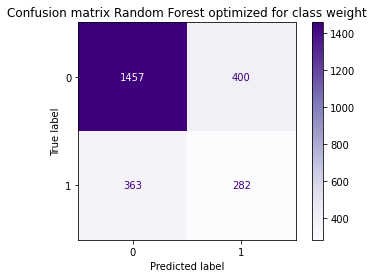

In [329]:
 plot_confusion_matrix(rfc, Xts_p, y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Purples)
    
plt.title('Confusion matrix Random Forest optimized for class weight')

Xalt 6 features

further analysis with X

In [330]:
# yts_proba=rfc.predict_proba(Xts_p)

In [331]:
# rfc.classes_

In [332]:
# yts_proba

In [333]:
# ytr_pred=rfc.predict(Xtr_sp)

In [334]:
# skplt.metrics.plot_roc_curve(yts_ros,y_proba)

In [335]:
yts_i=pd.DataFrame(y_test,index=X_test.index)
yts_ip=pd.DataFrame(yts_pred,index=X_test.index)

In [336]:
yts_i.head()

,0
4503,0
4957,0
6453,0
4317,0
3521,0


In [337]:
yts_i[0].value_counts()

0    1857
1     645
Name: 0, dtype: int64

In [338]:
X_test.columns

Index(['no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_funds_sold_12M_1',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
       'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'sales_curr',
       'sales_12M_2018', 'redemption_curr', 'redemption_12M',
       'new_Fund_added_12M_2018', 'aum_AC_EQUITY',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MULTIPLE',
       'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_TARGET', 'aum_P_529', 'aum_P_CEF',
       'aum_P_MF', 'aum_P_SMA', 'aum_P_UIT', 'ma1', 'ma2', 'ma3', 'ma4', 'ma5',
       'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'fid1', 'fid2', 'fid3', 'fid4',
       'fid5', 'fid6'],
      dtype='object')

In [339]:
# df

In [340]:
X_test2=X_test.copy()

In [341]:
X_test2['sales_2018']=X_test2['sales_12M_2018']+X_test2['sales_curr']
X_test2['redemption']=X_test2['redemption_curr']+X_test2['redemption_12M']

In [342]:
df2=pd.concat((X_test2[['ch1', 'ch2', 'ch3', 'ch4',
       'ch5', 'fid1', 'fid2', 'fid3', 'fid4', 'fid5', 'fid6','sales_2018',
                          'redemption','No_of_fund_curr','No_of_fund_curr',
                           'no_of_funds_sold_12M_1','no_of_sales_12M_1',
                           'no_of_Redemption_12M_1','no_of_assetclass_sold_12M_1','new_Fund_added_12M_2018'
                          ]],yts_i),axis=1)
df2.rename({0: 'new_Fund_added_2019'},axis=1,inplace=True)
df2=pd.concat((df2,yts_ip), axis=1)
df2.rename({0:'new_Fund_added_2019_pred'},axis=1,inplace=True)

In [343]:
df2.head()

,ch1,ch2,ch3,ch4,ch5,fid1,fid2,fid3,fid4,fid5,...,redemption,No_of_fund_curr,No_of_fund_curr,no_of_funds_sold_12M_1,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_assetclass_sold_12M_1,new_Fund_added_12M_2018,new_Fund_added_2019,new_Fund_added_2019_pred
4503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4957,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.9225,1.0,1.0,2.0,4.0,1.0,2.0,1.0,0,1
6453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,145226.4700,0.0,0.0,1.0,12.0,6.0,1.0,0.0,0,0
4317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0,0
3521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.0,2.0,2.0,4.0,0.0,1.0,2.0,0,0


In [344]:
for cs in chis:
    for idy,xs in df2.iterrows():
        if xs[cs]==1.0:
            sbstr=chdec.get(cs)
            df2.loc[idy,'Sub channel']=sbstr         
df2.head()

,ch1,ch2,ch3,ch4,ch5,fid1,fid2,fid3,fid4,fid5,...,No_of_fund_curr,No_of_fund_curr,no_of_funds_sold_12M_1,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_assetclass_sold_12M_1,new_Fund_added_12M_2018,new_Fund_added_2019,new_Fund_added_2019_pred,Sub channel
4503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NACS
4957,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,4.0,1.0,2.0,1.0,0,1,NACS
6453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,12.0,6.0,1.0,0.0,0,0,IBD
4317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0,0,IBD
3521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,4.0,0.0,1.0,2.0,0,0,IBD


In [345]:
for fs in fis:
    for idf,xf in df2.iterrows():
        if xf[fs]==1.0:
            sbstr=fdec.get(fs)
            df2.loc[idf,'Firm name']=sbstr         
df2.head(10)

,ch1,ch2,ch3,ch4,ch5,fid1,fid2,fid3,fid4,fid5,...,No_of_fund_curr,no_of_funds_sold_12M_1,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_assetclass_sold_12M_1,new_Fund_added_12M_2018,new_Fund_added_2019,new_Fund_added_2019_pred,Sub channel,Firm name
4503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NACS,otherid
4957,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,4.0,1.0,2.0,1.0,0,1,NACS,otherid
6453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,12.0,6.0,1.0,0.0,0,0,IBD,otherid
4317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0,0,IBD,otherid
3521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,4.0,0.0,1.0,2.0,0,0,IBD,otherid
4417,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,IBD,otherid
9992,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0,0,NACS,1567450
1360,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,16.0,2.0,1.0,1.0,0,0,IBD,otherid
2054,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,5.0,3.0,1.0,0.0,1,0,IBD,1471422
3535,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,IBD,0022885


In [346]:
df2['Sub channel'].value_counts()

IBD          1676
NACS          761
RIA            57
USBT            4
other sub       4
Name: Sub channel, dtype: int64

In [347]:
df2.loc[df2['Sub channel'] == 'USBT']

,ch1,ch2,ch3,ch4,ch5,fid1,fid2,fid3,fid4,fid5,...,No_of_fund_curr,no_of_funds_sold_12M_1,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_assetclass_sold_12M_1,new_Fund_added_12M_2018,new_Fund_added_2019,new_Fund_added_2019_pred,Sub channel,Firm name
9851,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,USBT,otherid
2142,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,10.0,90.0,292.0,3.0,1.0,1,1,USBT,otherid
1695,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,7.0,26.0,176.0,3.0,1.0,0,0,USBT,otherid
4341,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,USBT,otherid


In [348]:
df2.loc[df2['Sub channel'] == 'other sub']

,ch1,ch2,ch3,ch4,ch5,fid1,fid2,fid3,fid4,fid5,...,No_of_fund_curr,no_of_funds_sold_12M_1,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_assetclass_sold_12M_1,new_Fund_added_12M_2018,new_Fund_added_2019,new_Fund_added_2019_pred,Sub channel,Firm name
9212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,other sub,otherid
4462,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,other sub,otherid
362,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,other sub,otherid
7550,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,other sub,otherid


In [349]:
# len(df2['decile'].value_counts().tolist())

In [350]:
# deciles=df2['decile'].unique().tolist()
# deciles

In [351]:

df2.to_csv('class_ch_fi2.csv')

# Hyperaramter Tuning